In [59]:
import numpy as np
import random as rd
import multiprocessing
from joblib import Parallel, delayed
import pickle
import time
import matplotlib.pyplot as plt


In [66]:
#génération de Dirichlet utilisant des Beta (la fonction np bugge pour des paramètres trop petits)
def gen_dirichlet (params) : 
    if any (params<=0) : 
        print (params)
        params [params<0]=0.0000001
    if sum(params[1:])<=0 : 
        return(params[0])
    xs = [np.random.beta(params[0], sum(params[1:]))]
    for j in range(1,len(params)-1):
        phi = np.random.beta(params[j], sum(params[j+1:]))
        xs.append((1-sum(xs)) * phi)
    xs.append(1-sum(xs))
    return(np.array(xs))

#génère une ligne par acceptation rejet : 
#1) une Dirichlet est générée selon les paramètres param
#2) elle est multipliée par freq, la "frequency" de la ligne à compléter
#3) on teste si elle respecte les "frequencies" de la ligne de départ : on ne peut pas donner plus de terre que ce que contient le tas d'arrivée !  
#4) Si on a vraiment trop d'intération dans l'algorithme AR, on génère une ligne par défaut. 
#Cette solution permet d'éviter que la fonction bugge, mais elle se traduit par une montée brusque de la fonction objectif.
def generer_ligne(params, freq, freqs, max_iter =10000) :
    n_echecs = 0
    if freq == 0: 
        return(np.zeros(len(freqs)))
    ligne = np.zeros(np.shape(params))
    if any(params>0) : 
        for i in range(max_iter) : 
            ligne [params>0] = freq*gen_dirichlet(params[params>0])
            if all(ligne <= freqs) : 
                return(ligne)
    ligne = freqs*freq/sum(freqs)
    return(ligne)

#un exemple
params = np.array([0.1, 0.1, 0.7, 0])
freq =0.6
freqs = np.array([0.5, 0.1, 0.25, 0.15])
test = generer_ligne(params, freq, freqs)
print("ligne générée", test)
print("elle somme à" , sum(test))


ligne générée [ 0.37522259  0.06815981  0.1566176   0.        ]
elle somme à 0.6


In [67]:
#Version bavarde de la construction de la matrice en épis
def construct_matrice (freq_initial, freq_final, params) :
    freq_initial=freq_initial.copy() 
    freq_final=freq_final.copy()
    params=params.copy()
    n = len(freq_initial)
    n_echecs = 0
    matrice = np.zeros(np.shape(params))
    print("matrice vide")
    print(matrice)
    print("")
    
    for i in range(n-2) : 
        print("iteration",i)
        
        new = generer_ligne(params[i,i:n ], freq_initial [i], freq_final[i:])
        matrice[i, i:] = new
        freq_final[i:]  = freq_final[i:] - new
        freq_initial[i]=0

        print(matrice)
        print("somme par lignes")
        print(np.sum(matrice, axis=1))
        print("somme par colonnes")
        print(np.sum(matrice, axis=0))
        print("")
        
        new  = generer_ligne(params[i+1:,i], freq_final [i], freq_initial[i+1:])
        matrice[i+1:,i]  = new
        freq_initial[i+1:]  = freq_initial[i+1:] - new
        freq_final[i] = 0
        
        print(matrice)
        print("somme par lignes")
        print(np.sum(matrice, axis=1))
        print("somme par colonnes")
        print(np.sum(matrice, axis=0))
        print("")
        print("")

    print("iteration",n-2)
    new = generer_ligne(params[n-2,n-2:n ], freq_initial [n-2], freq_final[n-2:])
    matrice[n-2,n-2:n] = new
    freq_final[n-2:]  = freq_final[n-2:] - new

    print(matrice)
    print("somme par lignes")
    print(np.sum(matrice, axis=1))
    print("somme par colonnes")
    print(np.sum(matrice, axis=0))
    print("")
    matrice[n-1, n-2:n] = freq_final[n-2:]
    print(matrice)
    print("somme par lignes")
    print(np.sum(matrice, axis=1))
    print("somme par colonnes")
    print(np.sum(matrice, axis=0))
    print("")
        
freq_initial, freq_final, params = np.array([0.1, 0.1, 0.1, 0.7]) , np.array([0.3, 0.3, 0.3, 0.1]), np.array([[1,1,1,1],[1,1,1,1],[1,1,1,1],[1,1,1,1]]) 

construct_matrice (freq_initial=freq_initial, freq_final=freq_final, params=params)




matrice vide
[[ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]]

iteration 0
[[ 0.02537877  0.06235872  0.00088463  0.01137789]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
somme par lignes
[ 0.1  0.   0.   0. ]
somme par colonnes
[ 0.02537877  0.06235872  0.00088463  0.01137789]

[[ 0.02537877  0.06235872  0.00088463  0.01137789]
 [ 0.02339784  0.          0.          0.        ]
 [ 0.06006988  0.          0.          0.        ]
 [ 0.19115351  0.          0.          0.        ]]
somme par lignes
[ 0.1         0.02339784  0.06006988  0.19115351]
somme par colonnes
[ 0.3         0.06235872  0.00088463  0.01137789]


iteration 1
[[ 0.02537877  0.06235872  0.00088463  0.01137789]
 [ 0.02339784  0.0130515   0.05366355  0.00988711]
 [ 0.06006988  0.          0.          0.        ]
 [ 0.19115351  0.          0.          0.        ]]
somme par lignes
[ 0.1 

In [68]:
#version non bavarde de la construction de la matrice en épis
def construct_matrice (freq_initial, freq_final, params) :
    freq_initial=freq_initial.copy() 
    freq_final=freq_final.copy()
    params=params.copy()
    n = len(freq_initial)
    matrice = np.zeros(np.shape(params))
    
    for i in range(n-2) : 
        
        new = generer_ligne(params[i,i:n ], freq_initial [i], freq_final[i:])
        matrice[i, i:] = new
        freq_final[i:]  = freq_final[i:] - new
        freq_initial[i]=0

        new  = generer_ligne(params[i+1:,i], freq_final [i], freq_initial[i+1:])
        matrice[i+1:,i]  = new
        freq_initial[i+1:]  = freq_initial[i+1:] - new
        freq_final[i] = 0
        
    new = generer_ligne(params[n-2,n-2:n ], freq_initial [n-2], freq_final[n-2:])
    matrice[n-2,n-2:n] = new
    freq_final[n-2:]  = freq_final[n-2:] - new

    matrice[n-1, n-2:n] = freq_final[n-2:]
    
    return(matrice)

#fonction de renormalisation des paramètres
#Le but est de renormaliser les paramètres en suivant la structure en épis : les paramètres d'un "grain" de l'épi somment à 1
#Il s'agit de contrôler la variance des Dirichlet qui vont générer les paramètres
def renorm (matrice) :
    n = np.shape(matrice)[1]
    
    for i in range(n-2) : 
        matrice[i, i:] = matrice[i, i:]/sum(matrice[i, i:])
        matrice[i+1:,i]  = matrice[i+1:,i]/sum(matrice[i+1:,i])
    matrice[n-2,n-2:n] = matrice[n-2,n-2:n]/sum(matrice[n-2,n-2:n])
    matrice[n-1, n-2:n] = matrice[n-1, n-2:n]/sum(matrice[n-1, n-2:n])
    
    return(matrice)

In [71]:
np.random.seed(123)

#Algorithme inspiré de Cross Entropy

def CE_optimizer (freq_initial, freq_final, M, max_iter = 150) : 
    
    #retours
    minis =[]
    maxis = []
    lower =0 
    best_transports = []
    best_transport = 0
    time_simulations = []
    parametres = []
    
    #paramètres initiaux
    params = np.ones(shape = (len(freq_initial), len(freq_initial)))*0.001
    
    #on classe les "frequencies" par ordre croissant. 
    #Le but est d'éviter : 
    #1) qu'une frequency trop élevée en début d'épi ne sature les frequencies plus faibles
    #2) et que l'algorithme AR ne dépasse son seuil d'itérations max
    freq_initial = np.sort(freq_initial)
    freq_final = np.sort(freq_final)
    
    for i in range (max_iter) : 
        
   #Génération des particules     
        #nombre de partiules adaptatif, pour bien explorer au début
        n_particles = int(500 + 10000/(i+1))        
        particles = []
        start = time.time()
        for j in range(n_particles) : 
            particles.append(construct_matrice(freq_initial, freq_final, params))
        end = time.time()-start
        
    #Calcul des distances
        distances = []
        for matrice in particles : 
            distances.append(np.sum(np.multiply(matrice, M)))
        maxi=max(distances)
        mini=min(distances)
        params = np.zeros(shape = (len(freq_initial), len(freq_initial)))
        
    #Mise à jour des paramètres
        #moyenne des paramètres des 200 premières particules
        for j in np.argsort(distances)[0:200] : 
            params +=particles [j] 
        params += params/21
        #le but est de créer de la variance au cours des premières étapes, et au contraire de faire diminuer la variance par la suite
        if i <5 : 
            params +=0.01
        else : 
            params += -0.001
        #on multiplie les paramètres des Dirichlet afin de les concentrer autour des paramètres. 
        renorm(params)
        params = 20*renorm(params)
        
    #Mise à jour des retours
        #journal des itérations
        print("iteration", i)
        print("mini = ", mini)
        print("maxi = ", maxi)
        print("")
        #mise à jour des retours
        minis.append(mini)
        maxis.append(maxi)
        parametres.append(params)
        for j in np.where(distances == mini)[0] : 
            best_transports.append(particles[j] )
        if mini < lower : 
            lower = mini
            for j in np.where(distances == mini)[0] : 
                best_transport = particles[j]
        time_simulations.append(end/n_particles)
        
    return(dict(lower=lower,best_transport=best_transport, minis = minis, maxis=maxis, best_transports=best_transports, time_simulations=time_simulations))

M = np.ones((20, 20))-np.identity(20)

freq_initial = np.random.gamma(1, 1, 20)
freq_final = np.random.gamma(1, 1, 20)
freq_final = freq_final*sum(freq_initial)/sum(freq_final)
test_1 = CE_optimizer (freq_initial, freq_final, M)


iteration 0
mini =  10.7849716895
maxi =  16.7915986423

iteration 1
mini =  11.4485902096
maxi =  13.6360121531

iteration 2
mini =  10.992022
maxi =  13.0418287232

iteration 3
mini =  10.288642017
maxi =  12.4571048907

iteration 4
mini =  9.85827714018
maxi =  11.7956810138

iteration 5
mini =  9.08220946104
maxi =  11.2630709551

iteration 6
mini =  8.95858848622
maxi =  10.864552732

iteration 7
mini =  8.49112593094
maxi =  10.4074584671

iteration 8
mini =  8.12978423413
maxi =  10.0669382904

iteration 9
mini =  7.7950426117
maxi =  11.0796737902

iteration 10
mini =  7.66303626776
maxi =  9.49687623682

iteration 11
mini =  7.35546489886
maxi =  9.13128159774

iteration 12
mini =  6.95999851049
maxi =  8.90433344653

iteration 13
mini =  6.73136207159
maxi =  8.88080614109

iteration 14
mini =  6.51322037264
maxi =  8.40379847427

iteration 15
mini =  6.247944224
maxi =  8.24407468122

iteration 16
mini =  5.92726724685
maxi =  8.65245780787

iteration 17
mini =  7.1818726132

iteration 142
mini =  2.62729800021
maxi =  4.56653571336

iteration 143
mini =  2.62447826463
maxi =  4.78297221874

iteration 144
mini =  2.49785602299
maxi =  4.20546642264

iteration 145
mini =  2.51688258958
maxi =  4.3390043025

iteration 146
mini =  2.48676836351
maxi =  4.49722492312

iteration 147
mini =  2.46792712863
maxi =  5.78393941163

iteration 148
mini =  2.46763814188
maxi =  5.00861033374

iteration 149
mini =  2.45116928263
maxi =  5.31979012477



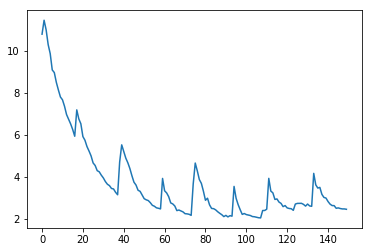

In [52]:
#évolution des meilleures distances
plt.plot (test_1["minis"])
plt.show()



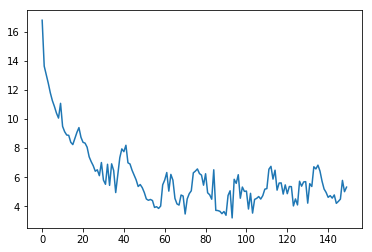

In [53]:
#évolution des pires distances
plt.plot (test_1["maxis"])
plt.show()

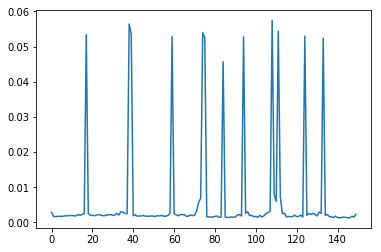

In [54]:
#évolution du temps de simulation
plt.plot(test_1["time_simulations"])
plt.show()

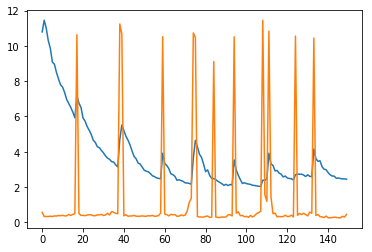

In [55]:
#évolution des meilleures distances + temps de simulation
renorm = np.max(test_1["minis"])/np.max(test_1["time_simulations"])
plt.plot (test_1["minis"])
plt.plot(np.array(test_1["time_simulations"])*renorm)
plt.show()

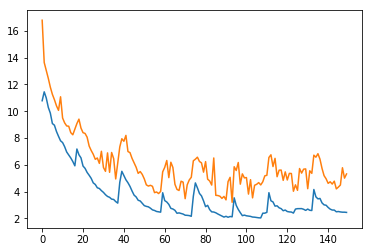

In [56]:
#évolution des meilleures et pires distances
plt.plot (test_1["minis"])
plt.plot (test_1["maxis"])
plt.show()